In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from glob import glob
import os
from PIL import Image

In [2]:
#pytorch
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torch.utils.data import DataLoader,Dataset
from torchvision import models,transforms

In [3]:
#sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

## Read in Metadata

In [4]:
skin_df = pd.read_csv('data/HAM10000_metadata.csv')

In [5]:
skin_df.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear


Let's take a look at the 7 types of skin lesions

In [6]:
skin_df['dx'].value_counts()

nv       6705
mel      1113
bkl      1099
bcc       514
akiec     327
vasc      142
df        115
Name: dx, dtype: int64

For future processing, we need to convert our label to numbers

In [7]:
skin_df['cell_type_idx'] = pd.Categorical(skin_df['dx']).codes

In [8]:
skin_df['cell_type_idx'].value_counts()

5    6705
4    1113
2    1099
1     514
0     327
6     142
3     115
Name: cell_type_idx, dtype: int64

## Read in Image

We have the data in the form of images, and we want to convert them into matrix format that works well with PyTorch

The first step is to match up the image filenames with their corresponding image id

In [9]:
data_dir = '../SkinLesionClassifier_data'
all_image_path = glob(os.path.join(data_dir, '*', '*.jpg'))
imageid_path_dict = {os.path.splitext(os.path.basename(x))[0]: x for x in all_image_path}

In [10]:
skin_df['path'] = skin_df['image_id'].map(imageid_path_dict.get)

In [11]:
skin_df.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization,cell_type_idx,path
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,2,None
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,2,None
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,2,None
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,2,None
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,2,None


## Data Preprocessing

### Fliter for unique lesion_id

Now we want to see if `lesion_id` is unique and keep only unduplicated images

In [13]:
# this will tell us how many images are associated with each lesion_id
df_undup = skin_df.groupby('lesion_id').count()
# now we filter out lesion_id's that have only one image associated with it
df_undup = df_undup[df_undup['image_id'] == 1]
df_undup.reset_index(inplace=True)
df_undup.shape

(5514, 9)

In [14]:
unique_id = pd.Series(df_undup['lesion_id'].unique())
skin_df_uniq = skin_df[skin_df['lesion_id'].isin(unique_id)]
skin_df_uniq.shape

(5514, 9)

In [15]:
# read in image and resize it to 100 x 100

In [16]:
#skin_df_uniq['image'] = skin_df_uniq['path'].map(lambda x: np.asarray(Image.open(x).resize((100,100))))
skin_df_uniq['image'] = skin_df_uniq['path'].map(lambda x: np.asarray(Image.open(x)))

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [17]:
skin_df_uniq.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization,cell_type_idx,path,image
10,HAM_0001396,ISIC_0025276,bkl,histo,55.0,female,trunk,2,../SkinLesionClassifier_data/HAM10000_images_p...,"[[[22, 13, 16], [22, 11, 15], [22, 11, 15], [2..."
15,HAM_0007207,ISIC_0031326,bkl,histo,65.0,male,back,2,../SkinLesionClassifier_data/HAM10000_images_p...,"[[[202, 160, 180], [198, 159, 178], [197, 160,..."
20,HAM_0006071,ISIC_0032343,bkl,histo,70.0,female,face,2,../SkinLesionClassifier_data/HAM10000_images_p...,"[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ..."
33,HAM_0005612,ISIC_0024981,bkl,histo,80.0,male,scalp,2,../SkinLesionClassifier_data/HAM10000_images_p...,"[[[204, 209, 213], [205, 204, 209], [205, 203,..."
34,HAM_0005388,ISIC_0027815,bkl,histo,80.0,male,chest,2,../SkinLesionClassifier_data/HAM10000_images_p...,"[[[0, 0, 0], [0, 0, 0], [1, 1, 1], [6, 4, 7], ..."


### Train and test split

Next, we want to split the data into training and test sets

In [18]:
features = skin_df_uniq.drop('cell_type_idx', axis = 1)
target = skin_df_uniq['cell_type_idx']

In [194]:
x_train_o, x_test_o, Y_train, Y_test = train_test_split(features, target, test_size=0.20,random_state=118)

In [195]:
x_train_o = x_train_o.reset_index(drop = True)
x_test_o = x_test_o.reset_index(drop = True)
Y_train = Y_train.reset_index(drop = True)
Y_test = Y_test.reset_index(drop = True)

### Imbalance class

We noticed from earlier that class 'nv' has dominated significantly more than the other classes. To ease future trouble cased by imbalanced classes, we will manually create more training samples for the other classes.

In [182]:
#x_train_o['cell_type_idx'].
Y_train['cell_type_idx'].value_counts(normalize = True)
#.value_counts()

0    0.026525
4    0.042847
1    0.030605
5    0.800045
2    0.081387
6    0.011789
3    0.006801
Name: cell_type_idx, dtype: float64

In [226]:
# Copy fewer class to balance the number of 7 classes 
data_aug_rate = [30,25,8,100,15,0,50]
df_train = x_train_o.copy()
df_train['cell_type_idx'] = Y_train
#cell_type_dict = dict(zip(x_train_o['dx'], Y_train))
#for celltype in list(x_train_o['dx'].unique()):
    #i = cell_type_dict[celltype]
for i in range(7):
    if data_aug_rate[i]:
        df_train=df_train.append([df_train.loc[df_train['cell_type_idx'] == i,:]]*(data_aug_rate[i]-1), ignore_index=True)

df_train['dx'].value_counts()

nv       3529
akiec    3510
bcc      3375
df       3000
bkl      2872
mel      2835
vasc     2600
Name: dx, dtype: int64

In [227]:
X_train = df_train.drop('cell_type_idx', axis = 1).reset_index(drop=True)
Y_train = df_train['cell_type_idx'].reset_index(drop=True)

In [247]:
Y_train = pd.Series([int(x) for x in Y_train])

### Normalization

To reduce bias among the pictures, we standardlize the images base on their theoretical mean and standard deviation

In [133]:
def compute_img_mean_std(df):
    img_RGB = df['image'].values
    RGB_vals = []
    # for each image, get the mean for each RGB layer
    for i in range(len(img_RGB)):
        R = img_RGB[i][:,:,0]
        G = img_RGB[i][:,:,1]
        B = img_RGB[i][:,:,2]
        RGB_vals.append([np.mean(R)/255, np.mean(G)/255, np.mean(B)/255])
    # compute mean and std
    RGB_vals = np.array(RGB_vals)
    img_mean = np.mean(RGB_vals, axis = 0)
    img_std = np.std(RGB_vals, axis = 0)
    return img_mean, img_std
        

In [228]:
train_mean, train_std = compute_img_mean_std(X_train)
test_mean, test_std = compute_img_mean_std(x_test_o)

In [229]:
print(train_mean, train_std)

[0.77658539 0.55929676 0.58420874] [0.0890289  0.08319234 0.08973768]


In [230]:
print(test_mean, test_std)

[0.79933838 0.52175165 0.53925165] [0.08701616 0.08624265 0.09363755]


## Image transformation

In [243]:
# define an image loader
# this part is inspired 
# https://www.kaggle.com/xinruizhuang/skin-lesion-classification-acc-90-pytorch#Step-1.-Data-analysis-and-preprocessing
class HAM10000(Dataset):
    def __init__(self, X, Y, transform=None):
        self.X = X
        self.Y = Y
        self.transform = transform

    def __len__(self):
        return len(self.Y)

    def __getitem__(self, index):
        # Load data and get label
        X = Image.open(self.X['path'][index])
        #X = self.X
        #y = torch.tensor(int(self.df['cell_type_idx'][index]))
        y = torch.tensor(Y_train.values[index])

        if self.transform:
            X = self.transform(X)

        return X, y

In [244]:
input_size = 100
train_transform = transforms.Compose([transforms.Resize((input_size,input_size)),transforms.RandomHorizontalFlip(),
                                      transforms.RandomVerticalFlip(),transforms.RandomRotation(20),
                                      transforms.ColorJitter(brightness=0.1, contrast=0.1, hue=0.1),
                                        transforms.ToTensor(),
                                     transforms.Normalize(train_mean, train_std)])
# define the transformation of the val images.
test_transform = transforms.Compose([transforms.Resize((input_size,input_size)), transforms.ToTensor(),
                                    transforms.Normalize(test_mean, test_std)])

In [248]:
training_set = HAM10000(X_train,Y_train, transform=train_transform)
trainloader = DataLoader(training_set, batch_size=32, shuffle=True, num_workers=4)

testing_set = HAM10000(x_test_o, Y_test,transform=test_transform)
testloader = DataLoader(testing_set, batch_size=32, shuffle=True, num_workers=4)

In [249]:
## try if trainloader is working
for i, data in enumerate(trainloader, 0):
    # Get the inputs.
    inputs, labels = data
    if i == 1:
        print(inputs.shape)
        print(labels)
        break

torch.Size([32, 3, 100, 100])
tensor([6, 3, 6, 3, 0, 0, 2, 4, 5, 6, 5, 5, 4, 0, 0, 5, 2, 1, 2, 0, 6, 2, 2, 4,
        2, 0, 1, 2, 6, 0, 6, 3])


## Network definition

In [221]:
# If there are GPUs, choose the first one for computing. Otherwise use CPU.
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)  
# If 'cuda:0' is printed, it means GPU is available.

cuda:0


First let's try a two-layer CNN

In [233]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        ###### Fill the blank here ######
        # conv layer
        self.conv1 = nn.Conv2d(3, 32, 3, stride = 1, padding = 1)
        self.conv2 = nn.Conv2d(32, 32, 3, stride = 1, padding = 1)
        
        # linear layer
        #self.fc1 = nn.Linear(20 * 8 * 8, 1280) 
        self.fc2 = nn.Linear(20000,32)
        self.fc3 = nn.Linear(32, 7)
       
        
    def forward(self, x):
        ###### Fill the blank here ######
        # two rounds of avg pooling
        # avg pooling over a (2, 2) window
        x = F.avg_pool2d(F.relu(self.conv1(x)), (2, 2))
        # If the size is a square you can only specify a single number
        x = F.avg_pool2d(F.relu(self.conv2(x)), 2)
        
        
        x = x.view(-1, self.num_flat_features(x))
        #x = self.fc1(x)
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
 
        return x

    def num_flat_features(self, x): # flatten matrix
        size = x.size()[1:]  # all dimensions except the batch dimension
        num_features = 1
        for s in size:
            num_features *= s
        return num_features

net = Net()     # Create the network instance.
net.to(device)  # Move the network parameters to the specified device.

Net(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc2): Linear(in_features=20000, out_features=32, bias=True)
  (fc3): Linear(in_features=32, out_features=7, bias=True)
)

#### Optimizer and Loss Function

In [250]:
# We use cross-entropy as loss function.
loss_func = nn.CrossEntropyLoss()  
# We use stochastic gradient descent (SGD) as optimizer.
opt = optim.SGD(net.parameters(), lr=0.001, momentum=0.9) 

## Training Procedure

In [251]:
avg_losses = []   # Avg. losses.
epochs = 10       # Total epochs.
print_freq = 100  # Print frequency.

for epoch in range(epochs):  # Loop over the dataset multiple times.
    running_loss = 0.0       # Initialize running loss.
    for i, data in enumerate(trainloader, 0):
        # Get the inputs.
        inputs, labels = data
        
        # Move the inputs to the specified device.
        inputs, labels = inputs.to(device), labels.to(device)
        
        # Zero the parameter gradients.
        opt.zero_grad()

        # Forward step.
        outputs = net(inputs)
        loss = loss_func(outputs, labels)
        
        # Backward step.
        loss.backward()
        
        # Optimization step (update the parameters).
        opt.step()

        # Print statistics.
        running_loss += loss.item()
        if i % print_freq == print_freq - 1: # Print every several mini-batches.
            avg_loss = running_loss / print_freq
            print('[epoch: {}, i: {:5d}] avg mini-batch loss: {:.3f}'.format(
                epoch, i, avg_loss))
            avg_losses.append(avg_loss)
            running_loss = 0.0

print('Finished Training.')

[epoch: 0, i:    99] avg mini-batch loss: 1.724
[epoch: 0, i:   199] avg mini-batch loss: 1.531
[epoch: 0, i:   299] avg mini-batch loss: 1.465
[epoch: 0, i:   399] avg mini-batch loss: 1.373
[epoch: 0, i:   499] avg mini-batch loss: 1.330
[epoch: 0, i:   599] avg mini-batch loss: 1.306
[epoch: 1, i:    99] avg mini-batch loss: 1.252
[epoch: 1, i:   199] avg mini-batch loss: 1.231
[epoch: 1, i:   299] avg mini-batch loss: 1.156
[epoch: 1, i:   399] avg mini-batch loss: 1.162
[epoch: 1, i:   499] avg mini-batch loss: 1.115
[epoch: 1, i:   599] avg mini-batch loss: 1.123
[epoch: 2, i:    99] avg mini-batch loss: 1.070
[epoch: 2, i:   199] avg mini-batch loss: 1.040
[epoch: 2, i:   299] avg mini-batch loss: 1.040
[epoch: 2, i:   399] avg mini-batch loss: 1.028
[epoch: 2, i:   499] avg mini-batch loss: 1.018
[epoch: 2, i:   599] avg mini-batch loss: 0.972
[epoch: 3, i:    99] avg mini-batch loss: 0.934
[epoch: 3, i:   199] avg mini-batch loss: 0.944
[epoch: 3, i:   299] avg mini-batch loss

#### Training Loss Curve

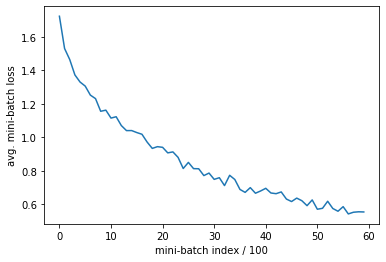

In [252]:
plt.plot(avg_losses)
plt.xlabel('mini-batch index / {}'.format(print_freq))
plt.ylabel('avg. mini-batch loss')
plt.show()

#### Evaluate on Test Dataset

In [156]:
# Check several images.
## (SKIPPED for now)
dataiter = iter(testloader)
images, labels = dataiter.next()
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))
outputs = net(images.to(device))
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join('%5s' % classes[predicted[j]]
                              for j in range(4)))

NameError: name 'imshow' is not defined

In [253]:
# Get test accuracy.
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the 10000 test images: 49 %


In [259]:
# Get test accuracy for each class.
classes = list(skin_df_uniq['dx'].unique())
class_correct = list(0. for i in range(7))
class_total = list(0. for i in range(7))

y_label = []
y_predict = []


with torch.no_grad():
    for data in testloader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        
        y_label.extend(labels.cpu().numpy())
        y_predict.extend(np.squeeze(predicted.cpu().numpy().T))

        for i in range(len(labels)):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1

for i in range(7):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of   bkl :  8 %
Accuracy of    nv :  2 %
Accuracy of    df : 18 %
Accuracy of   mel :  0 %
Accuracy of  vasc : 12 %
Accuracy of   bcc : 58 %
Accuracy of akiec :  0 %


In [255]:
pd.Series(y_predict).value_counts()

5    626
2    189
1    103
4     73
6     50
0     36
3     26
dtype: int64

In [256]:
print(classification_report(y_label, y_predict, target_names=classes))

              precision    recall  f1-score   support

         bkl       0.06      0.08      0.07        24
          nv       0.01      0.03      0.01        36
          df       0.10      0.19      0.13        95
         mel       0.00      0.00      0.00         4
        vasc       0.07      0.12      0.09        41
         bcc       0.83      0.58      0.68       893
       akiec       0.00      0.00      0.00        10

    accuracy                           0.49      1103
   macro avg       0.15      0.14      0.14      1103
weighted avg       0.68      0.49      0.57      1103

